In [17]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import re
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import spacy
import unicodedata
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import emoji
from nltk.stem.snowball import RussianStemmer
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.base import BaseEstimator, TransformerMixin

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79501\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79501\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   -- ------------------------------------- 1.3/24.0 MB 6.1 MB/s eta 0:00:04
   -- ------------------------------------- 1.6/24.0 MB 6.5 MB/s eta 0:00:04
   ------ --------------------------------- 3.9/24.0 MB 6.3 MB/s eta 0:00:04
   --------- ------------------------------ 5.5/24.0 MB 6.3 MB/s eta 0:00:03
   ---------- ----------------------------- 6.6/24.0 MB 6.7 MB/s eta 0:00:03
   -------------- ------------------------- 8.7/24.0 MB 6.7 MB/s eta 0:00:03
   ---------------- ----------------------- 9.7/24.0 MB 6.6 MB/s eta 0:00:03
   ------------------ --------------------- 11.0/24.0 MB 6.6 MB/s eta 0:00:02
   -------------------- ------------------- 12.1/24.0 MB 6.4 MB/s eta 0:00:02
   --------------------- ------------------ 13.1/24.0 MB 6.2 MB/s eta 0:00:02
   ----------------------- ---------------- 13.9/24.0 MB 6.0 MB/s eta 0:00:02
   ------

  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
df = pd.read_csv('train_data.csv')

In [3]:
stemmer = RussianStemmer()

# Функция для преобразования эмоджи в слова
def emojis_words(text):
    clean_text = emoji.demojize(text, delimiters=(" ", " "))
    clean_text = clean_text.replace(":", "").replace("_", " ")
    return clean_text

# Функция очистки текста
def clean_text(input_text):
    # HTML-теги
    clean_text = re.sub('<[^<]+?>', '', input_text)

    # URL и ссылки
    clean_text = re.sub(r'http\S+', '', clean_text)

    # Эмоджи и эмотиконы
    clean_text = emojis_words(clean_text)

    # Приведение к нижнему регистру
    clean_text = clean_text.lower()

    # Убираем лишние пробелы
    clean_text = re.sub('\s+', ' ', clean_text)

    # Преобразование символов с диакритическими знаками
    clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Разворачиваем сокращения
    clean_text = contractions.fix(clean_text)

    # Убираем специальные символы
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)

    # Удаление стоп-слов с использованием NLTK
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(clean_text)
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens)

    return clean_text

# Функция лемматизации с использованием spacy
def lemmatize_spacy(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized_tokens)

# Основная функция для обработки текста
def preprocess_text(text):
    # Приведение текста к нижнему регистру
    text = text.lower()
    # Удаление чисел и специальных символов
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Токенизация
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # Удаление стоп-слов (если используете русский язык)
    stop_words = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word not in stop_words]
    stem_tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(stem_tokens)



In [4]:
df['text'] = df['Тема'] + ' ' + df['Описание']

In [59]:
df['text'] = df['text'].apply(preprocess_text)

# Разделение данных на обучающую и тестовую выборки
X = df['text']
y = df['Тип оборудования']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
category_counts = y_train.value_counts()
category_counts

Тип оборудования
Ноутбук    121
Сервер      26
СХД          8
Name: count, dtype: int64

In [61]:
category_counts = y_test.value_counts()
category_counts

Тип оборудования
Ноутбук    33
СХД         3
Сервер      3
Name: count, dtype: int64

In [14]:
df['text'].isna().sum()

0

In [9]:
param_grid = {
    'vectorizer__max_features': [1000, 5000],  # Разные значения для max_features
    'catboostclassifier__iterations': [200, 500],  # Количество итераций
    'catboostclassifier__learning_rate': [0.01, 0.1],  # Скорость обучения
    'catboostclassifier__depth': [4, 6],  # Глубина дерева
    'catboostclassifier__l2_leaf_reg': [3, 5]  # Регуляризация для CatBoost
}

In [22]:
class ADASYNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.adasyn = ADASYN(random_state=self.random_state)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if y is not None:
            X_res, y_res = self.adasyn.fit_resample(X, y)
            self.y_resampled = y_res  # Сохраняем y_res для доступа из вне, если необходимо
            return X_res
        else:
            return X


pipeline = Pipeline([
    ('adasyn', ADASYNTransformer(random_state=42)),  # Шаг с ADASYN
    ('vectorizer', TfidfVectorizer()),  # Векторизатор, будет заменяться в GridSearchCV
    ('catboost', CatBoostClassifier(verbose=0))
])

# Гиперпараметры для поиска
param_grid = {
    'vectorizer__max_features': [1000, 5000],  # Разные значения для max_features
    'vectorizer__ngram_range': [(1, 2)],
    'catboost__iterations': [200, 350, 500],  # Количество итераций
    'catboost__bootstrap_type': ['Bayesian', 'Bernoulli'],
    'catboost__learning_rate': [0.01, 0.1],  # Скорость обучения
    'catboost__depth': [3, 4],  # Глубина дерева
    'catboost__l2_leaf_reg': [12, 14]  # Регуляризация для CatBoost
}

# Подбор гиперпараметров с GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Обучение с GridSearchCV
grid_search.fit(X_train, y_train)

# Лучшие параметры и результаты
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая F1-меры на кросс-валидации: {grid_search.best_score_:.4f}")

# Оценка на тестовых данных
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-меры на тестовой выборке: {f1:.4f}")

Лучшие параметры: {'catboost__bootstrap_type': 'Bayesian', 'catboost__depth': 3, 'catboost__iterations': 350, 'catboost__l2_leaf_reg': 12, 'catboost__learning_rate': 0.1, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Лучшая F1-меры на кросс-валидации: 0.9790
F1-меры на тестовой выборке: 0.8863


In [ ]:
class SMOTETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.SMOTE = SMOTE(random_state=self.random_state)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if y is not None:
            X_res, y_res = self.SMOTE.fit_resample(X, y)
            self.y_resampled = y_res  # Сохраняем y_res для доступа из вне, если необходимо
            return X_res
        else:
            return X


pipeline = Pipeline([
    ('SMOTE', SMOTETransformer(random_state=42)),  # Шаг с ADASYN
    ('vectorizer', CountVectorizer()),  # Векторизатор, будет заменяться в GridSearchCV
    ('catboost', CatBoostClassifier(verbose=0))
])

# Гиперпараметры для поиска
param_grid = {
    'vectorizer__max_features': [1000, 5000],  # Разные значения для max_features
    'catboost__iterations': [200, 350, 500],  # Количество итераций
    'catboost__bootstrap_type': ['Bayesian', 'Bernoulli'],
    'catboost__learning_rate': [0.01, 0.1],  # Скорость обучения
    'catboost__depth': [3, 4],  # Глубина дерева
    'catboost__l2_leaf_reg': [10, 15]  # Регуляризация для CatBoost
}

# Подбор гиперпараметров с GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Обучение с GridSearchCV
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Лучшие параметры и результаты
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая F1-меры на кросс-валидации: {grid_search.best_score_:.4f}")

# Оценка на тестовых данных
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-меры на тестовой выборке: {f1:.4f}")

Лучшие параметры: {'catboost__depth': 4, 'catboost__iterations': 350, 'catboost__l2_leaf_reg': 10, 'catboost__learning_rate': 0.1, 'vectorizer__max_features': 1000}
Лучшая F1-меры на кросс-валидации: 0.9790
F1-меры на тестовой выборке: 0.8863


In [26]:
best_params = grid_search.best_params_

In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Векторизатор, будет заменяться в GridSearchCV
    ('catboost', CatBoostClassifier(verbose=0))
])

# Гиперпараметры для поиска
param_grid = {
    'vectorizer__max_features': [1000, 5000],  # Разные значения для max_features
    'catboost__iterations': [200, 350, 500, 700],  # Количество итераций
    'catboost__learning_rate': [0.01, 0.1],  # Скорость обучения
    'catboost__depth': [3, 4],  # Глубина дерева
    'catboost__l2_leaf_reg': [10, 15]  # Регуляризация для CatBoost
}

# Подбор гиперпараметров с GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Обучение с GridSearchCV
grid_search.fit(X_train, y_train)

# Лучшие параметры и результаты
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая F1-меры на кросс-валидации: {grid_search.best_score_:.4f}")

# Оценка на тестовых данных
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-меры на тестовой выборке: {f1:.4f}")

Лучшие параметры: {'catboost__depth': 3, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 10, 'catboost__learning_rate': 0.1, 'vectorizer__max_features': 1000}
Лучшая F1-меры на кросс-валидации: 0.9716
F1-меры на тестовой выборке: 0.8863


In [89]:
from imblearn.over_sampling import ADASYN

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=1000, ngram_range= (1, 2))  # Убедитесь, что max_features корректно установлен

adasyn = ADASYN(random_state=42)

# Преобразование текста
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_train_res, y_train_res = adasyn.fit_resample(X_train_vec, y_train)

feature_names = vectorizer.get_feature_names_out()
word_index = feature_names.tolist().index("ноутбук")
X_train_res[:, word_index] = X_train_res[:, word_index] * 3


# Обучение модели CatBoost без GridSearchCV
model = CatBoostClassifier(depth=best_params['catboost__depth'],
    iterations=best_params['catboost__iterations'],
    bootstrap_type=best_params['catboost__bootstrap_type'],
    l2_leaf_reg=best_params['catboost__l2_leaf_reg'],
    learning_rate=best_params['catboost__learning_rate'], verbose=0)
model.fit(X_train_res, y_train_res)

# Оценка модели
y_pred = model.predict(X_test_vec)

# Вычисление F1-меры
f1 = f1_score(y_test, y_pred, average='weighted')  # average='weighted' для многоклассовой классификации
print(f"F1-меры на тестовой выборке: {f1:.4f}")

F1-меры на тестовой выборке: 0.8872


In [34]:
y_pred

array([['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Сервер'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Сервер'],
       ['Сервер'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Сервер'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук'],
       ['Ноутбук']], dtype=object)

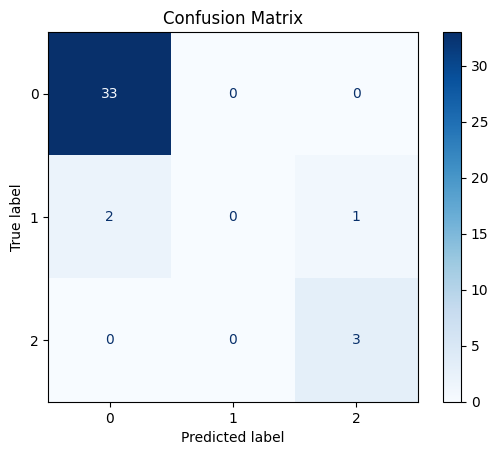

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [107]:
errors_df = pd.DataFrame({
    'text': list(X_test),
    'true_label': list(y_test),
    'predicted_label': list(y_pred)
})

# Фильтруем только ошибочные предсказания
errors_df = errors_df[errors_df['true_label'] != errors_df['predicted_label']]


In [108]:
errors_df 

,text,true_label,predicted_label
2,СИЛА СХ2-4115-12; СИЛА CX2-4016-25; СИЛА СХ2-4...,СХД,[Ноутбук]
8,по неисправной плашке памяти на dd203 - Enclos...,СХД,[Ноутбук]
16,Неисправность диска Enclosure=6:Disk=32 dd202 ...,СХД,[Ноутбук]


In [101]:
errors_df.to_excel('errors.xlsx')

In [94]:
model.save_model('catboost_model.cbm')

In [96]:
import joblib
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [109]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import re
import emoji
import unicodedata
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
import numpy as np

# Ваши функции
class PreprocessText(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = SnowballStemmer('russian')

    def emojis_words(self, text):
        clean_text = emoji.demojize(text, delimiters=(" ", " "))
        clean_text = clean_text.replace(":", "").replace("_", " ")
        return clean_text

    def clean_text(self, input_text):
        clean_text = re.sub('<[^<]+?>', '', input_text)
        clean_text = re.sub(r'http\S+', '', clean_text)
        clean_text = self.emojis_words(clean_text)
        clean_text = clean_text.lower()
        clean_text = re.sub('\s+', ' ', clean_text)
        clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        clean_text = contractions.fix(clean_text)
        clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)
        stop_words = set(stopwords.words('russian'))
        tokens = word_tokenize(clean_text)
        tokens = [token for token in tokens if token not in stop_words]
        clean_text = ' '.join(tokens)
        return clean_text

    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        stop_words = set(stopwords.words('russian'))
        tokens = [word for word in tokens if word not in stop_words]
        stem_tokens = [self.stemmer.stem(word) for word in tokens]
        return ' '.join(stem_tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess_text)


class ADASYNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.adasyn = ADASYN(random_state=self.random_state)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if y is not None:
            X_res, y_res = self.adasyn.fit_resample(X, y)
            self.y_resampled = y_res  # Сохраняем y_res для доступа из вне, если необходимо
            return X_res
        else:
            return X


# Подготовка данных
best_params = {'catboost__bootstrap_type': 'Bayesian', 'catboost__depth': 3, 'catboost__iterations': 350, 
                'catboost__l2_leaf_reg': 12, 'catboost__learning_rate': 0.1, 
                'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}

X = df['Тема'] + ' ' + df['Описание']
y = df['Тип оборудования']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Составление пайплайна
pipeline = Pipeline([
    ('preprocessor', PreprocessText()),  # Обработка текста
    ('adasyn', ADASYNTransformer(random_state=42)),
    ('vectorizer', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),  # Векторизация текста
    ('classifier', CatBoostClassifier(  depth=best_params['catboost__depth'],
                                        iterations=best_params['catboost__iterations'],
                                        bootstrap_type=best_params['catboost__bootstrap_type'],
                                        l2_leaf_reg=best_params['catboost__l2_leaf_reg'],
                                        learning_rate=best_params['catboost__learning_rate'], verbose=0))  
])

# Обучение пайплайна
pipeline.fit(X_train, y_train)

# Оценка модели
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')  
print(f"F1-меры на тестовой выборке: {f1:.4f}")

F1-меры на тестовой выборке: 0.8863


In [110]:
joblib.dump(pipeline, 'catboost_pipeline.pkl')

['catboost_pipeline.pkl']